In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cnv_profile import CNV_Profile
from plot_cnv_profile import plot_acr_static

## Get cytobands

In [4]:
import sys
sys.path.append('/home/cmesser/HapASeg')
from hapaseg.utils import parse_cytoband

Could not load reference genome!


Cannot find path to gnomAD index; gnomAD functionality disabled.


In [5]:
cband = pd.read_csv('../cnv_data/cytoBand.hg38.txt', sep = "\t", names = ["chr", "start", "end", "band", "stain"])
cband

,chr,start,end,band,stain
0,chr1,0,2300000,p36.33,gneg
1,chr1,2300000,5300000,p36.32,gpos25
2,chr1,5300000,7100000,p36.31,gneg
3,chr1,7100000,9100000,p36.23,gpos25
4,chr1,9100000,12500000,p36.22,gneg
...,...,...,...,...,...
857,chrY,12400000,17100000,q11.221,gpos50
858,chrY,17100000,19600000,q11.222,gneg
859,chrY,19600000,23800000,q11.223,gpos50
860,chrY,23800000,26600000,q11.23,gneg


In [6]:
centromere_df = parse_cytoband('../cnv_data/cytoBand.hg38.txt')
centromere_df.loc[centromere_df[centromere_df['start'] == 0].index, 'arm'] = 'p'
centromere_df.loc[centromere_df[centromere_df['start'] != 0].index, 'arm'] = 'q'

centromere_spec_df = centromere_df.set_index(['chr', 'arm']).unstack()[[('start', 'q'), ('end', 'p')]]
centromere_spec_df['avg'] = centromere_spec_df.mean(axis=1).astype(int)
centromere_spec_df['list'] = centromere_spec_df.apply(lambda x: [int(x[('end', 'p')]), int(x[('start', 'q')])], axis=1)
centromere_spec_df.columns = centromere_spec_df.columns.droplevel(1)
centromere_spec_df.index = centromere_spec_df.index.map(str)

In [9]:
centromere_avg_center = centromere_spec_df.to_dict()['avg']
centromere_span_center = centromere_spec_df.to_dict()['list']

## Get Simulated CNV Profile

In [45]:
import importlib
import cnv_profile
importlib.reload(cnv_profile)
from cnv_profile import CNV_Profile

In [46]:
default_profile = CNV_Profile(num_subclones=3, csize='../cnv_data/genome.hg38.txt', cent_loc=centromere_avg_center)
default_profile.add_cnv_events(arm_num=10, focal_num=100, p_whole=0.6, ratio_clonal=0.5,
                       median_focal_length=1.8 * 10**6)
default_profile.add_arm(2, 1, chrom='1')
default_profile.calculate_cnv_profile()
default_profile.calculate_df_profiles()

In [47]:
default_profile.cnv_profile_df

,Chromosome,Start.bp,End.bp,mu.major,mu.minor
0,1,74435510,184472883,1.681335,1.000000
1,1,184472883,185103869,1.681335,0.000000
2,1,185103869,248956422,1.681335,1.000000
3,1,71847607,74435510,1.681335,0.000000
4,1,7796871,71847607,1.681335,1.000000
...,...,...,...,...,...
2,24,18497804,19546998,2.000000,1.000000
3,24,18103175,18497804,2.000000,1.149688
4,24,47402083,57227415,1.000000,1.000000
5,24,1,16884105,1.000000,1.000000


In [54]:
default_profile.cnv_profile_df.sort_values(['Chromosome', 'Start.bp'], key=natsort.natsort_keygen()).to_csv('./test/simulation/genome_1.txt', sep='\t', index=False)

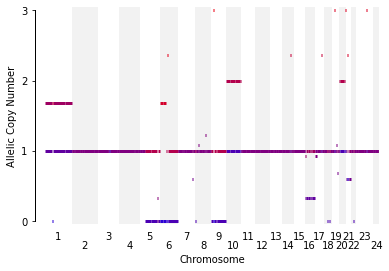

In [48]:
fig, ax = plt.subplots(1,1)

fig = plot_acr_static(default_profile.cnv_profile_df, ax, default_profile.csize, segment_colors='difference', sigmas=False, min_seg_lw=3, y_upper_lim=3)


In [101]:
# Generate TEST binned coverage profile (for WGS)

test_binned_coverage = pd.read_csv('../cnv_data/1Mb.genome_bins.hg38.bed', sep='\t', header=None, names=['chrom', 'start_pos', 'end_pos'])

dispersion_norm = np.random.normal(0, 10, test_binned_coverage.shape[0])
binned_coverage = 30 * (test_binned_coverage['end_pos'] - test_binned_coverage['start_pos'])
# this_chr_coverage = np.asarray([np.random.poisson(cov + np.exp(disp)) for cov, disp in
#                                zip(binned_coverage, dispersion_norm)])  # would need to calculate sum of binned log NP 
this_chr_coverage = np.random.poisson(binned_coverage)
test_binned_coverage['cov'] = this_chr_coverage
test_binned_coverage['chrom'] = test_binned_coverage['chrom'].apply(lambda x: x[3:])
test_binned_coverage.to_csv('./test/simulation/binned_coverage.test', sep='\t', index=False)

In [51]:
# SAVE COVERAGE FILE

default_profile.save_coverage_file('./test/simulation/NA12878.WGS.genome_1.pur_0_7.txt', 0.7, '../cnv_data/NA12878.WGS.hg38.binned_coverage.bed') #'./test/simulation/binned_coverage.test'


In [107]:
# Generate test VCF file with depth

test_vcf = pd.read_csv('../HapASeg/simulation/NA12878/VCF/NA12878.vcf', sep='\t', comment='#', header=None, 
                     names=['CHROM','POS','ID','REF','ALT','QUAL','FILTER','INFO','FORMAT','NA12878'])
test_vcf = test_vcf[['CHROM', 'POS']].rename(columns={'CHROM': 'chr', 'POS': 'pos'})

dispersion_norm = np.random.normal(0, 2, test_vcf.shape[0])
this_chr_coverage = np.asarray([np.random.poisson(30 + np.exp(disp)) for disp in dispersion_norm])
test_vcf['depth'] = this_chr_coverage
test_vcf['chr'] = test_vcf['chr'].apply(lambda x: x[3:])
test_vcf.to_csv('./test/simulation/test_hets.txt', sep='\t', index=False)

In [58]:
# SAVE HETS FILE
default_profile.save_hets_file('./test/simulation/NA12878.WGS.vcf_depths.genome_1.pur_0_7.txt', '../HapASeg/simulation/NA12878/VCF/NA12878.vcf', '../cnv_data/NA12878_WGS.vcf.depths.bed', 0.7)  # './test/simulation/test_hets.txt'


In [59]:
test_hets_file = pd.read_csv('./test/simulation/NA12878.WGS.vcf_depths.genome_1.pur_0_7.txt', sep='\t')
test_hets_file[(test_hets_file['REF_COUNT'] > 10) & (test_hets_file['ALT_COUNT'] > 10)]

,CONTIG,POSITION,REF_COUNT,ALT_COUNT
2,1,740738,24,20
20,1,789680,159,115
22,1,792149,19,20
26,1,797392,23,22
36,1,805514,19,31
...,...,...,...,...
4167762,23,155422097,23,12
4167803,23,155443920,19,24
4167832,23,155522299,16,15
4167844,23,155532668,17,17
